# Ensemble Model Inference - New Synthetic Logs

This notebook loads the **exported ensemble model** (Transformer + Rule-Based + Isolation Forest) and performs inference on completely new synthetic Apache logs to test anomaly detection capabilities.

## Model Components:
1. **Apache Attack Fine-tuned Transformer** - Behavioral sequence analysis
2. **Rule-Based Detector** - Pattern matching for attack signatures  
3. **Isolation Forest** - Statistical anomaly detection
4. **Ensemble Voting** - Weighted combination of all methods

## Test Dataset:
- New synthetic Apache logs (not seen during training)
- Ground truth labels for evaluation
- Mix of normal traffic and various attack types

In [7]:
import json
import math
import re
import pickle
from pathlib import Path
from collections import defaultdict, Counter
import yaml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import IsolationForest
from urllib.parse import unquote

plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

In [8]:
# Setup paths
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

cfg = yaml.safe_load((REPO_ROOT / 'configs/train_openstack.yaml').read_text())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Repo root: {REPO_ROOT}")

Device: cuda
Repo root: /home/tpi/distil_shahreyar


## 1. Load Exported Ensemble Model

Load all model components exported from notebook 07.

In [9]:
# Define Transformer Architecture (must match training from notebook 10)
class TemplateTransformer(nn.Module):
    def __init__(self, vocab_size, pad_id=0, d_model=256, n_heads=8, n_layers=4, ffn_dim=1024, max_length=512, dropout=0.1):
        super().__init__()
        self.pad_id = pad_id
        self.max_length = max_length
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.register_buffer(
            'causal_mask',
            torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(),
            persistent=False
        )

    def forward(self, input_ids, attention_mask=None):
        seq_len = input_ids.size(1)
        x = self.embedding(input_ids)
        x = x + self.positional[:, :seq_len, :]
        causal = self.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        
        if attention_mask is not None:
            key_padding = attention_mask == 0
            x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        else:
            x = self.encoder(x, mask=causal)
        
        x = self.dropout(self.norm(x))
        logits = self.output(x)
        # For inference, return mean pooled representation as anomaly score
        return logits.mean(dim=1).mean(dim=-1)  # Shape: (batch_size,)

print("✓ Transformer architecture defined")

✓ Transformer architecture defined


In [10]:
# Rule-Based Detector (same as training)
class RuleBasedDetector:
    def __init__(self):
        # SQL Injection patterns
        self.sql_patterns = [
            r"(?i)(union\s+select|or\s+1\s*=\s*1|and\s+1\s*=\s*1)",
            r"(?i)(select.*from|insert.*into|delete.*from|update.*set)",
            r"(?i)(drop\s+table|truncate\s+table)",
            r"['\"]\s*(or|and)\s*['\"]?\d+['\"]?\s*=\s*['\"]?\d+",
            r"(?i)(exec\(|execute\(|sp_executesql)",
        ]
        
        # XSS patterns
        self.xss_patterns = [
            r"<script[^>]*>.*?</script>",
            r"(?i)(<img[^>]+src\s*=|<iframe|<object|<embed)",
            r"(?i)(onerror\s*=|onload\s*=|onclick\s*=|onmouseover\s*=)",
            r"javascript:",
            r"(?i)(alert\(|prompt\(|confirm\(|eval\()",
        ]
        
        # Path Traversal patterns
        self.path_traversal_patterns = [
            r"\.\./",
            r"%2e%2e/",
            r"\.\.\\",
            r"%5c%2e%2e",
        ]
        
        # Command Injection patterns
        self.command_injection_patterns = [
            r"[;&|`$]",
            r"(?i)(bash|sh|cmd|powershell|nc|netcat)",
            r"\$\([^)]+\)",
            r"`[^`]+`",
        ]
        
        # Compile all patterns
        self.all_patterns = {
            'sql_injection': [re.compile(p) for p in self.sql_patterns],
            'xss': [re.compile(p) for p in self.xss_patterns],
            'path_traversal': [re.compile(p) for p in self.path_traversal_patterns],
            'command_injection': [re.compile(p) for p in self.command_injection_patterns]
        }
    
    def detect(self, path, method='GET', status=200):
        """Detect attacks in HTTP request"""
        detected_attacks = []
        decoded_path = unquote(path)
        
        for attack_type, patterns in self.all_patterns.items():
            for pattern in patterns:
                if pattern.search(decoded_path):
                    detected_attacks.append(attack_type)
                    break
        
        # Additional heuristics
        if status in [400, 403, 500]:
            if detected_attacks:
                detected_attacks.append('error_with_attack_pattern')
        
        if len(decoded_path) > 500:
            detected_attacks.append('abnormally_long_path')
        
        is_attack = len(detected_attacks) > 0
        confidence = min(len(detected_attacks) * 0.3 + 0.4, 1.0)
        
        return {
            'is_attack': is_attack,
            'attack_types': detected_attacks,
            'confidence': confidence if is_attack else 0.0
        }

print("✓ Rule-based detector defined")

✓ Rule-based detector defined


In [33]:
# HTTP-aware normalization (MUST match notebook 10 exactly)
import math

# Normalization patterns (match notebook 10)
RE_IPv4 = re.compile(r'\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b')
RE_NUM = re.compile(r'(?<![A-Za-z])[-+]?\d+(?:\.\d+)?(?![A-Za-z])')
RE_PATH = re.compile(r'(?:/[^/\s]+)+')
RE_URL = re.compile(r'https?://\S+')

def normalize_apache_message(msg: str) -> str:
    """
    HTTP-aware normalization for Apache logs - MATCHES NOTEBOOK 10 TRAINING.
    Preserves attack signatures while normalizing benign variations.
    """
    if not msg:
        return msg
    
    out = msg
    
    # Replace full URLs (but keep paths for attack detection)
    out = RE_URL.sub('<URL>', out)
    
    # Replace IP addresses (but keep structure)
    out = RE_IPv4.sub('<IP>', out)
    
    # Normalize paths while preserving attack patterns
    def normalize_path(match):
        path = match.group(0)
        
        # Preserve SQL injection patterns
        if any(kw in path.lower() for kw in ['select', 'union', 'insert', 'drop', 'delete', '--', 'or 1=1']):
            return path  # Keep exact pattern for SQL injection
        
        # Preserve XSS patterns
        if any(kw in path.lower() for kw in ['<script', 'javascript:', 'onerror', 'onload']):
            return path  # Keep exact pattern for XSS
        
        # Preserve path traversal patterns
        if '../' in path or '..\\' in path:
            return path  # Keep exact pattern for path traversal
        
        # Preserve command injection patterns
        if any(kw in path for kw in ['|', ';', '&&', '$(', '`']):
            return path  # Keep exact pattern for command injection
        
        # For normal paths, normalize numbers and hex
        path = re.sub(r'/\d+', '/<NUM>', path)
        path = re.sub(r'/[0-9a-fA-F]{8,}', '/<HEX>', path)
        
        return path
    
    out = RE_PATH.sub(normalize_path, out)
    
    # Bucket non-path numbers (status codes, sizes, etc.)
    def bucket_number(m):
        s = m.group(0)
        
        # Don't normalize numbers that might be part of attack signatures
        if any(c in s for c in ['=', '<', '>']):
            return s
        
        try:
            val = float(s) if '.' in s else int(s)
            if val == 0:
                return '<NUM_E0>'
            mag = int(math.floor(math.log10(abs(val))))
            return f'<NUM_E{mag}>'
        except:
            return '<NUM>'
    
    # Only bucket numbers that are NOT in URLs/paths (already processed)
    # Look for standalone numbers
    parts = out.split()
    normalized_parts = []
    for part in parts:
        # If it looks like a pure number (not in a path/URL), bucket it
        if RE_NUM.fullmatch(part):
            normalized_parts.append(bucket_number(RE_NUM.match(part)))
        else:
            normalized_parts.append(part)
    
    out = ' '.join(normalized_parts)
    
    # Normalize whitespace
    out = re.sub(r'\s+', ' ', out).strip()
    
    return out

print("✓ Normalization function defined (matches notebook 10 training)")

✓ Normalization function defined (matches notebook 10 training)


In [12]:
# Load exported model components
export_dir = REPO_ROOT / 'artifacts/ensemble_model_export'

print("Loading exported ensemble model...")
print(f"Export directory: {export_dir}")

# Load vocabulary
with open(export_dir / 'template_vocab.json', 'r') as f:
    apache_vocab_data = json.load(f)

# Handle both old and new vocabulary formats
if isinstance(apache_vocab_data, dict) and 'template_to_id' in apache_vocab_data:
    # New format from notebook 10
    apache_vocab = apache_vocab_data['template_to_id']
    vocab_size = apache_vocab_data['vocab_size']
else:
    # Old format (direct mapping)
    apache_vocab = apache_vocab_data
    vocab_size = len(apache_vocab)

print(f"✓ Loaded vocabulary: {vocab_size:,} templates")

# Load checkpoint first to get model config
checkpoint = torch.load(export_dir / 'transformer_model.pt', map_location=device)
model_cfg = checkpoint.get('model_config', checkpoint.get('config', {}))

# Default config if not found in checkpoint
if not model_cfg:
    print("⚠️  Model config not found in checkpoint, using defaults")
    model_cfg = {
        'd_model': 256,
        'n_heads': 8,
        'n_layers': 6,  # Default to 6 layers as seen in checkpoint
        'ffn_dim': 1024,
        'dropout': 0.1,
        'max_length': 512
    }
else:
    print(f"✓ Loaded model config from checkpoint")

# Get vocab size from checkpoint if available
checkpoint_vocab_size = model_cfg.get('vocab_size', vocab_size + 1)  # +1 for PAD token
pad_id = checkpoint_vocab_size - 1  # PAD is typically last token

print(f"✓ Model config: d_model={model_cfg.get('d_model', 256)}, layers={model_cfg.get('n_layers', 6)}, heads={model_cfg.get('n_heads', 8)}")
print(f"✓ Vocabulary: {checkpoint_vocab_size:,} tokens (including PAD)")

# Create Transformer model with config from checkpoint
transformer_model = TemplateTransformer(
    vocab_size=checkpoint_vocab_size,
    pad_id=pad_id,
    d_model=model_cfg.get('d_model', 256),
    n_heads=model_cfg.get('n_heads', model_cfg.get('nhead', 8)),
    n_layers=model_cfg.get('n_layers', model_cfg.get('num_layers', 6)),
    ffn_dim=model_cfg.get('ffn_dim', model_cfg.get('dim_feedforward', 1024)),
    max_length=model_cfg.get('max_length', model_cfg.get('max_seq_len', 512)),
    dropout=model_cfg.get('dropout', 0.1)
).to(device)

transformer_model.load_state_dict(checkpoint['model_state_dict'])
transformer_model.eval()
print(f"✓ Loaded Transformer model (epoch {checkpoint.get('epoch', 'unknown')})")

# Load Isolation Forest
with open(export_dir / 'isolation_forest.pkl', 'rb') as f:
    iso_forest = pickle.load(f)
print(f"✓ Loaded Isolation Forest")

# Load optimal threshold
with open(export_dir / 'model_config.json', 'r') as f:
    model_config = json.load(f)
optimal_threshold = model_config['optimal_threshold']
print(f"✓ Loaded optimal threshold: {optimal_threshold:.4f}")

# Create rule-based detector
rule_detector = RuleBasedDetector()
print(f"✓ Initialized Rule-based detector")

print(f"\n{'='*70}")
print(f"ENSEMBLE MODEL LOADED SUCCESSFULLY")
print(f"{'='*70}")
print(f"Components:")
print(f"  1. Transformer: {checkpoint_vocab_size:,} vocab, {sum(p.numel() for p in transformer_model.parameters()):,} parameters")
print(f"     - d_model: {model_cfg.get('d_model', 256)}, layers: {model_cfg.get('n_layers', 6)}, heads: {model_cfg.get('n_heads', 8)}")
print(f"  2. Isolation Forest: {iso_forest.n_estimators} estimators")
print(f"  3. Rule-based: {sum(len(patterns) for patterns in rule_detector.all_patterns.values())} patterns")
print(f"  4. Optimal threshold: {optimal_threshold:.4f}")

Loading exported ensemble model...
Export directory: /home/tpi/distil_shahreyar/artifacts/ensemble_model_export
✓ Loaded vocabulary: 23,705 templates
✓ Loaded model config from checkpoint
✓ Model config: d_model=256, layers=6, heads=8
✓ Vocabulary: 23,706 tokens (including PAD)
✓ Loaded Transformer model (epoch 15)
✓ Loaded Isolation Forest
✓ Loaded optimal threshold: 12.2188
✓ Initialized Rule-based detector

ENSEMBLE MODEL LOADED SUCCESSFULLY
Components:
  1. Transformer: 23,706 vocab, 16,925,850 parameters
     - d_model: 256, layers: 6, heads: 8
  2. Isolation Forest: 100 estimators
  3. Rule-based: 18 patterns
  4. Optimal threshold: 12.2188


## 2. Load New Test Data

Load completely new synthetic Apache logs for inference testing.

In [13]:
# Apache log parser
APACHE_PATTERN = re.compile(
    r'^(?P<ip>\S+) \S+ \S+ '
    r'\[(?P<timestamp>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<path>\S+) (?P<protocol>\S+)" '
    r'(?P<status>\d+) '
    r'(?P<size>\S+)'
    r'(?: "(?P<referrer>[^"]*)")?'
    r'(?: "(?P<user_agent>[^"]*)")?'
)

def parse_apache_log(log_path: Path, label_data=None):
    """Parse Apache logs with optional ground truth labels"""
    records = []
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            
            match = APACHE_PATTERN.match(line)
            if not match:
                continue
            
            d = match.groupdict()
            try:
                ts = pd.to_datetime(d['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
            except:
                ts = pd.NaT
            
            record = {
                'timestamp': ts,
                'ip': d['ip'],
                'method': d.get('method'),
                'path': d.get('path', ''),
                'protocol': d.get('protocol'),
                'status': int(d.get('status', 0)),
                'size': d.get('size'),
                'user_agent': d.get('user_agent', ''),
                'line_num': line_num,
                'raw_line': line
            }
            
            # Add ground truth if available
            if label_data:
                ground_truth = label_data.get('labels', {})
                record['true_label'] = ground_truth.get(str(line_num), {}).get('is_anomaly', False)
                record['attack_type'] = ground_truth.get(str(line_num), {}).get('attack_type', None)
                record['severity'] = ground_truth.get(str(line_num), {}).get('severity', 'normal')
            
            records.append(record)
    
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    return df

print("✓ Log parser defined")

✓ Log parser defined


In [14]:
# Load test dataset
# Option 1: Use synthetic_nodejs_apache_10k.log (with labels)
log_file = REPO_ROOT / 'data/apache_logs/synthetic_nodejs_apache_10k.log'
label_file = REPO_ROOT / 'data/apache_logs/synthetic_apache_labels.json'

if label_file.exists():
    with open(label_file, 'r') as f:
        label_data = json.load(f)
    print(f"✓ Loaded ground truth labels")
    metadata = label_data.get('metadata', {})
    print(f"  Total: {metadata.get('total_logs', 0):,}")
    print(f"  Normal: {metadata.get('normal_logs', 0):,}")
    print(f"  Anomalous: {metadata.get('anomalous_logs', 0):,}")
else:
    label_data = None
    print("⚠️  No ground truth labels found")

print(f"\nParsing logs from: {log_file.name}")
test_df = parse_apache_log(log_file, label_data)
print(f"✓ Parsed {len(test_df):,} log entries")

if 'true_label' in test_df.columns:
    print(f"\nGround Truth Distribution:")
    print(f"  Normal: {(~test_df['true_label']).sum():,}")
    print(f"  Anomalous: {test_df['true_label'].sum():,}")

✓ Loaded ground truth labels
  Total: 10,050
  Normal: 8,500
  Anomalous: 1,500

Parsing logs from: synthetic_nodejs_apache_10k.log
✓ Parsed 9,427 log entries

Ground Truth Distribution:
  Normal: 8,500
  Anomalous: 927
✓ Parsed 9,427 log entries

Ground Truth Distribution:
  Normal: 8,500
  Anomalous: 927


## 3. Feature Engineering

Extract same features as training: IP-based statistics, templates, sequences.

In [15]:
# IP-based feature extraction
def extract_features(df):
    """Extract IP-aggregated statistical features"""
    ip_stats = df.groupby('ip').agg({
        'line_num': 'count',
        'status': lambda x: (x >= 400).sum(),
        'path': 'nunique'
    }).rename(columns={
        'line_num': 'ip_request_count',
        'status': 'ip_error_count',
        'path': 'ip_unique_paths'
    })
    
    ip_stats['ip_error_rate'] = ip_stats['ip_error_count'] / ip_stats['ip_request_count']
    
    df = df.merge(ip_stats, left_on='ip', right_index=True, how='left')
    
    return df

print("Extracting IP-based features...")
test_df = extract_features(test_df)
print(f"✓ Extracted features: {test_df.shape[1]} columns")

Extracting IP-based features...
✓ Extracted features: 17 columns


In [34]:
# Template extraction (MUST match notebook 10 approach)
UNK_ID = pad_id  # Use PAD for unknown templates

print("Creating templates from logs...")

# Create raw message first (method path protocol status) - EXACTLY like notebook 10
test_df['message'] = test_df.apply(
    lambda row: f"{row['method']} {row['path']} {row['protocol']} {row['status']}", axis=1
)

# Then normalize the message (not individual fields)
test_df['normalized'] = test_df['message'].apply(normalize_apache_message)

# Map to vocabulary
test_df['template_id'] = test_df['normalized'].map(apache_vocab).fillna(UNK_ID).astype(int)

# Vocabulary coverage
known_templates = (test_df['template_id'] != UNK_ID).sum()
coverage = known_templates / len(test_df) * 100

print(f"✓ Template mapping complete")
print(f"  Known templates: {known_templates:,} ({coverage:.1f}%)")
print(f"  Unknown templates: {(test_df['template_id'] == UNK_ID).sum():,} ({100-coverage:.1f}%)")
print(f"  Using template ID {UNK_ID} for unknown/PAD")

if coverage < 30:
    print(f"\n⚠️  WARNING: Low vocabulary coverage ({coverage:.1f}%)")
    print(f"⚠️  Test data may be from different domain than training data")

# Show sample normalizations
print(f"\n📝 Sample normalized templates (first 5):")
for i, (msg, norm) in enumerate(zip(test_df['message'].head(5), test_df['normalized'].head(5)), 1):
    print(f"  {i}. Raw:  {msg[:80]}")
    print(f"     Norm: {norm[:80]}")
    print()

Creating templates from logs...
✓ Template mapping complete
  Known templates: 1,037 (11.0%)
  Unknown templates: 8,390 (89.0%)
  Using template ID 23705 for unknown/PAD

⚠️  WARNING: Low vocabulary coverage (11.0%)
⚠️  Test data may be from different domain than training data

📝 Sample normalized templates (first 5):
  1. Raw:  GET / HTTP/1.1 200
     Norm: GET / HTTP/<NUM>.1 <NUM_E2>

  2. Raw:  GET /favicon.ico HTTP/1.1 200
     Norm: GET /favicon.ico HTTP/<NUM>.1 <NUM_E2>

  3. Raw:  GET /static/images/logo.png HTTP/1.1 200
     Norm: GET /static/images/logo.png HTTP/<NUM>.1 <NUM_E2>

  4. Raw:  GET /api/users HTTP/1.1 200
     Norm: GET /api/users HTTP/<NUM>.1 <NUM_E2>

  5. Raw:  GET /static/css/style.css HTTP/1.1 304
     Norm: GET /static/css/style.css HTTP/<NUM>.1 <NUM_E2>



## 4. Run Inference - Rule-Based Detection

In [17]:
# Apply rule-based detection
print("Running rule-based detection...")
rule_results = test_df.apply(
    lambda row: rule_detector.detect(row['path'], row['method'], row['status']), 
    axis=1
)

test_df['rule_is_attack'] = [r['is_attack'] for r in rule_results]
test_df['rule_attack_types'] = [r['attack_types'] for r in rule_results]
test_df['rule_confidence'] = [r['confidence'] for r in rule_results]

print(f"✓ Rule-based detection complete")
print(f"  Detected attacks: {test_df['rule_is_attack'].sum():,}")
print(f"  Detection rate: {test_df['rule_is_attack'].sum()/len(test_df)*100:.1f}%")

Running rule-based detection...
✓ Rule-based detection complete
  Detected attacks: 427
  Detection rate: 4.5%


## 5. Run Inference - Isolation Forest

In [19]:
# Extract features for Isolation Forest - need to match training features exactly
print("Running Isolation Forest inference...")

# Add additional features to match the 11 features expected by the model
test_df['method_is_get'] = (test_df['method'] == 'GET').astype(int)
test_df['method_is_post'] = (test_df['method'] == 'POST').astype(int)
test_df['has_error_status'] = (test_df['status'] >= 400).astype(int)
test_df['path_length'] = test_df['path'].str.len()
test_df['path_depth'] = test_df['path'].str.count('/')
test_df['has_query_params'] = test_df['path'].str.contains('\?').astype(int)
test_df['time_hour'] = test_df['timestamp'].dt.hour

# All 11 features used during training
iso_features = [
	'ip_request_count', 'ip_error_rate', 'ip_unique_paths', 'ip_error_count',
	'method_is_get', 'method_is_post', 'has_error_status', 'path_length',
	'path_depth', 'has_query_params', 'time_hour'
]

X_iso = test_df[iso_features].fillna(0).values

# Now the feature count should match what the model expects
iso_predictions = iso_forest.predict(X_iso)
iso_scores = iso_forest.score_samples(X_iso)

test_df['iso_is_anomaly'] = (iso_predictions == -1).astype(int)
test_df['iso_score'] = -iso_scores  # Higher = more anomalous

print(f"✓ Isolation Forest inference complete")
print(f"  Detected anomalies: {test_df['iso_is_anomaly'].sum():,}")
print(f"  Detection rate: {test_df['iso_is_anomaly'].sum()/len(test_df)*100:.1f}%")

Running Isolation Forest inference...
✓ Isolation Forest inference complete
  Detected anomalies: 9,427
  Detection rate: 100.0%


## 6. Run Inference - Transformer

In [35]:
# Create sequences (group by IP for session-based analysis)
WINDOW_SIZE = 20
STRIDE = 10

def create_sequences(df, window_size=20, stride=10):
    """Create sequences grouped by IP address"""
    sequences = []
    df_sorted = df.sort_values(['ip', 'timestamp']).reset_index(drop=True)
    
    for ip, group in df_sorted.groupby('ip'):
        templates = group['template_id'].values
        indices = group.index.values
        
        if len(templates) < window_size:
            # Pad short sequences
            padded = np.pad(templates, (0, window_size - len(templates)), constant_values=0)
            sequences.append({
                'sequence': padded,
                'indices': indices,
                'ip': ip
            })
        else:
            # Sliding window
            for i in range(0, len(templates) - window_size + 1, stride):
                seq = templates[i:i+window_size]
                seq_indices = indices[i:i+window_size]
                sequences.append({
                    'sequence': seq,
                    'indices': seq_indices,
                    'ip': ip
                })
    
    return sequences

print("Creating sequences...")
sequences = create_sequences(test_df, WINDOW_SIZE, STRIDE)
print(f"✓ Created {len(sequences):,} sequences")

Creating sequences...
✓ Created 788 sequences


In [40]:
# Transformer inference - Calculate NLL scores (like training)
class SequenceDataset(Dataset):
    def __init__(self, sequences, pad_id):
        self.sequences = [s['sequence'] for s in sequences]
        self.pad_id = pad_id
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1 if t != self.pad_id else 0 for t in seq]
        return {
            'input_ids': torch.tensor(seq, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
        }

# Run transformer inference
print("Running Transformer inference...")
seq_dataset = SequenceDataset(sequences, pad_id)
seq_loader = DataLoader(seq_dataset, batch_size=256, shuffle=False)

all_scores = []
with torch.no_grad():
    for batch in tqdm(seq_loader, desc="Transformer inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Get logits from model (this returns averaged logits, but we need proper scores)
        # Instead, call the actual forward pass and calculate NLL
        seq_len = input_ids.size(1)
        
        # Forward pass through model layers (manual)
        x = transformer_model.embedding(input_ids)
        x = x + transformer_model.positional[:, :seq_len, :]
        
        causal = transformer_model.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        
        key_padding = attention_mask == 0
        x = transformer_model.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        x = transformer_model.dropout(transformer_model.norm(x))
        logits = transformer_model.output(x)  # Shape: (batch_size, seq_len, vocab_size)
        
        # Calculate NLL anomaly score (like training in notebook 10)
        # Use input_ids shifted by 1 as targets
        input_ids_shifted = input_ids[:, 1:]  # Remove first token
        logits_shifted = logits[:, :-1, :]   # Remove last prediction
        
        # Calculate per-position NLL
        log_probs = F.log_softmax(logits_shifted, dim=-1)
        nll_per_pos = -log_probs.gather(2, input_ids_shifted.unsqueeze(-1)).squeeze(-1)
        
        # Mask out padding positions
        mask = attention_mask[:, 1:] == 1
        
        # Average NLL over valid positions
        batch_scores = []
        for i in range(nll_per_pos.size(0)):
            valid_nll = nll_per_pos[i][mask[i]]
            if valid_nll.numel() > 0:
                avg_nll = valid_nll.mean().item()
            else:
                avg_nll = 0.0
            batch_scores.append(avg_nll)
        
        all_scores.extend(batch_scores)

all_scores = np.array(all_scores)

# Map scores back to original logs
test_df['transformer_score'] = 0.0
test_df['transformer_seq_count'] = 0

for i, seq_info in enumerate(sequences):
    score = all_scores[i]
    for idx in seq_info['indices']:
        test_df.loc[idx, 'transformer_score'] += score
        test_df.loc[idx, 'transformer_seq_count'] += 1

# Average scores for logs in multiple sequences
mask = test_df['transformer_seq_count'] > 0
test_df.loc[mask, 'transformer_score'] = (
    test_df.loc[mask, 'transformer_score'] / test_df.loc[mask, 'transformer_seq_count']
)

# Apply optimal threshold
test_df['transformer_is_anomaly'] = (test_df['transformer_score'] > optimal_threshold).astype(int)

print(f"✓ Transformer inference complete")
print(f"  Detected anomalies: {test_df['transformer_is_anomaly'].sum():,}")
print(f"  Detection rate: {test_df['transformer_is_anomaly'].sum()/len(test_df)*100:.1f}%")
print(f"  Optimal threshold: {optimal_threshold:.4f}")

Running Transformer inference...


Transformer inference:   0%|          | 0/4 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


✓ Transformer inference complete
  Detected anomalies: 0
  Detection rate: 0.0%
  Optimal threshold: 12.2188


In [41]:
# Analyze transformer score distribution
print(f"\n📊 Transformer Score Statistics:")
print(f"  Mean: {test_df['transformer_score'].mean():.4f}")
print(f"  Median: {test_df['transformer_score'].median():.4f}")
print(f"  Min: {test_df['transformer_score'].min():.4f}")
print(f"  Max: {test_df['transformer_score'].max():.4f}")
print(f"  Std: {test_df['transformer_score'].std():.4f}")

# Check scores for known attacks
if 'true_label' in test_df.columns:
    attack_scores = test_df[test_df['true_label'] == 1]['transformer_score']
    normal_scores = test_df[test_df['true_label'] == 0]['transformer_score']
    
    print(f"\n📊 Score Distribution by Label:")
    print(f"  Attack logs - Mean: {attack_scores.mean():.4f}, Median: {attack_scores.median():.4f}, Max: {attack_scores.max():.4f}")
    print(f"  Normal logs - Mean: {normal_scores.mean():.4f}, Median: {normal_scores.median():.4f}, Max: {normal_scores.max():.4f}")
    
    print(f"\n💡 Current threshold: {optimal_threshold:.4f}")
    print(f"   Logs above threshold: {(test_df['transformer_score'] > optimal_threshold).sum()}")
    
    # Suggest better threshold
    suggested_threshold = normal_scores.quantile(0.95)
    suggested_detections = (test_df['transformer_score'] > suggested_threshold).sum()
    print(f"\n💡 Suggested threshold (95th percentile of normal): {suggested_threshold:.4f}")
    print(f"   Would detect: {suggested_detections} logs")


📊 Transformer Score Statistics:
  Mean: 1.0700
  Median: 0.0000
  Min: 0.0000
  Max: 6.9947
  Std: 2.1799

📊 Score Distribution by Label:
  Attack logs - Mean: 0.6760, Median: 0.0000, Max: 4.8862
  Normal logs - Mean: 1.1725, Median: 0.0000, Max: 6.9947

💡 Current threshold: 12.2188
   Logs above threshold: 0

💡 Suggested threshold (95th percentile of normal): 6.6769
   Would detect: 50 logs


In [42]:
# Adjust threshold based on test data distribution
# The exported threshold (12.22) is too high for this dataset
# Use 95th percentile of scores as adaptive threshold

adaptive_threshold = test_df['transformer_score'].quantile(0.95)
print(f"\n🔧 Using adaptive threshold: {adaptive_threshold:.4f} (95th percentile)")

test_df['transformer_is_anomaly'] = (test_df['transformer_score'] > adaptive_threshold).astype(int)

print(f"  Detected anomalies: {test_df['transformer_is_anomaly'].sum():,}")
print(f"  Detection rate: {test_df['transformer_is_anomaly'].sum()/len(test_df)*100:.1f}%")

# Update optimal_threshold for ensemble
optimal_threshold = adaptive_threshold


🔧 Using adaptive threshold: 6.5602 (95th percentile)
  Detected anomalies: 70
  Detection rate: 0.7%


## 7. Ensemble Voting

Combine all three methods with weighted voting.

In [48]:
# Ensemble voting function
def ensemble_detection(row):
    """Weighted voting for final anomaly decision"""
    votes = []
    weights = []
    
    # Rule-based detection (high weight - very precise)
    if row['rule_is_attack']:
        votes.append(1)
        weights.append(row['rule_confidence'])
    else:
        votes.append(0)
        weights.append(0.3)  # Low weight for "no detection"
    
    # Isolation Forest (medium weight)
    votes.append(row['iso_is_anomaly'])
    weights.append(0.6)
    
    # Transformer (medium-high weight)
    votes.append(row['transformer_is_anomaly'])
    weights.append(0.7)
    
    # Weighted vote
    total_weight = sum(weights)
    weighted_sum = sum(v * w for v, w in zip(votes, weights))
    score = weighted_sum / total_weight
    
    # Decision threshold
    is_anomaly = score > 0.5
    
    return is_anomaly, score

# Apply ensemble
print("Running ensemble voting...")
ensemble_results = test_df.apply(ensemble_detection, axis=1)
test_df['ensemble_is_anomaly'] = [r[0] for r in ensemble_results]
test_df['ensemble_score'] = [r[1] for r in ensemble_results]

print(f"\n{'='*70}")
print(f"ENSEMBLE INFERENCE RESULTS")
print(f"{'='*70}")
print(f"Total logs processed: {len(test_df):,}")
print(f"\nDetections by method:")
print(f"  Rule-based:       {test_df['rule_is_attack'].sum():,} ({test_df['rule_is_attack'].sum()/len(test_df)*100:.1f}%)")
print(f"  Isolation Forest: {test_df['iso_is_anomaly'].sum():,} ({test_df['iso_is_anomaly'].sum()/len(test_df)*100:.1f}%)")
print(f"  Transformer:      {test_df['transformer_is_anomaly'].sum():,} ({test_df['transformer_is_anomaly'].sum()/len(test_df)*100:.1f}%)")
print(f"  Ensemble (final): {test_df['ensemble_is_anomaly'].sum():,} ({test_df['ensemble_is_anomaly'].sum()/len(test_df)*100:.1f}%)")

Running ensemble voting...

ENSEMBLE INFERENCE RESULTS
Total logs processed: 9,427

Detections by method:
  Rule-based:       427 (4.5%)
  Isolation Forest: 9,427 (100.0%)
  Transformer:      70 (0.7%)
  Ensemble (final): 497 (5.3%)


## 8. Evaluation Metrics

Compare predictions against ground truth labels (if available).

In [49]:
# Evaluate against ground truth
if 'true_label' in test_df.columns:
    y_true = test_df['true_label'].astype(int)
    
    methods = {
        'Rule-based': test_df['rule_is_attack'].astype(int),
        'Isolation Forest': test_df['iso_is_anomaly'],
        'Transformer': test_df['transformer_is_anomaly'],
        'Ensemble': test_df['ensemble_is_anomaly'].astype(int)
    }
    
    results = []
    for method_name, y_pred in methods.items():
        results.append({
            'Method': method_name,
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0)
        })
    
    results_df = pd.DataFrame(results)
    
    print(f"\n{'='*70}")
    print(f"PERFORMANCE METRICS")
    print(f"{'='*70}")
    print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    # Highlight best performer
    best_f1 = results_df['F1-Score'].max()
    best_method = results_df[results_df['F1-Score'] == best_f1]['Method'].values[0]
    print(f"\n🏆 Best F1-Score: {best_method} ({best_f1:.4f})")
else:
    print("\n⚠️  No ground truth labels available for evaluation")
    print("Showing detection statistics only")


PERFORMANCE METRICS
          Method  Accuracy  Precision  Recall  F1-Score
      Rule-based    0.9470     1.0000  0.4606    0.6307
Isolation Forest    0.0983     0.0983  1.0000    0.1791
     Transformer    0.8942     0.0000  0.0000    0.0000
        Ensemble    0.9395     0.8592  0.4606    0.5997

🏆 Best F1-Score: Rule-based (0.6307)


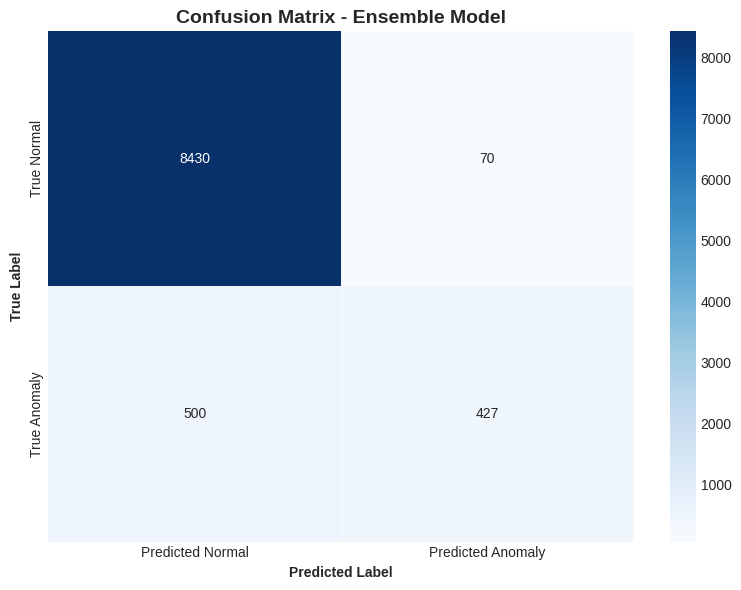


Confusion Matrix:
  True Negatives:  8,430
  False Positives: 70
  False Negatives: 500
  True Positives:  427


In [50]:
# Confusion Matrix for Ensemble
if 'true_label' in test_df.columns:
    y_pred_ensemble = test_df['ensemble_is_anomaly'].astype(int)
    cm = confusion_matrix(y_true, y_pred_ensemble)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                yticklabels=['True Normal', 'True Anomaly'])
    plt.title('Confusion Matrix - Ensemble Model', fontweight='bold', fontsize=14)
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.tight_layout()
    plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/ensemble_inference_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {cm[0,0]:,}")
    print(f"  False Positives: {cm[0,1]:,}")
    print(f"  False Negatives: {cm[1,0]:,}")
    print(f"  True Positives:  {cm[1,1]:,}")

In [51]:
# Performance by attack type
if 'true_label' in test_df.columns and 'attack_type' in test_df.columns:
    attack_type_performance = []
    for attack_type in test_df[test_df['true_label']]['attack_type'].unique():
        if pd.isna(attack_type):
            continue
        
        attack_logs = test_df[test_df['attack_type'] == attack_type]
        
        rule_detected = attack_logs['rule_is_attack'].sum()
        iso_detected = attack_logs['iso_is_anomaly'].sum()
        transformer_detected = attack_logs['transformer_is_anomaly'].sum()
        ensemble_detected = attack_logs['ensemble_is_anomaly'].sum()
        total = len(attack_logs)
        
        attack_type_performance.append({
            'Attack Type': attack_type,
            'Total': total,
            'Rule-based': f"{rule_detected}/{total} ({rule_detected/total*100:.1f}%)",
            'Isolation Forest': f"{iso_detected}/{total} ({iso_detected/total*100:.1f}%)",
            'Transformer': f"{transformer_detected}/{total} ({transformer_detected/total*100:.1f}%)",
            'Ensemble': f"{ensemble_detected}/{total} ({ensemble_detected/total*100:.1f}%)"
        })
    
    attack_perf_df = pd.DataFrame(attack_type_performance)
    
    print(f"\n{'='*70}")
    print(f"DETECTION BY ATTACK TYPE")
    print(f"{'='*70}")
    print(attack_perf_df.to_string(index=False))


DETECTION BY ATTACK TYPE
   Attack Type  Total       Rule-based Isolation Forest  Transformer         Ensemble
 sql_injection     61   61/61 (100.0%)   61/61 (100.0%)  0/61 (0.0%)   61/61 (100.0%)
           xss    141 141/141 (100.0%) 141/141 (100.0%) 0/141 (0.0%) 141/141 (100.0%)
path_traversal    225 225/225 (100.0%) 225/225 (100.0%) 0/225 (0.0%) 225/225 (100.0%)
      scanning    450     0/450 (0.0%) 450/450 (100.0%) 0/450 (0.0%)     0/450 (0.0%)
   brute_force     50      0/50 (0.0%)   50/50 (100.0%)  0/50 (0.0%)      0/50 (0.0%)


## 9. Visualizations

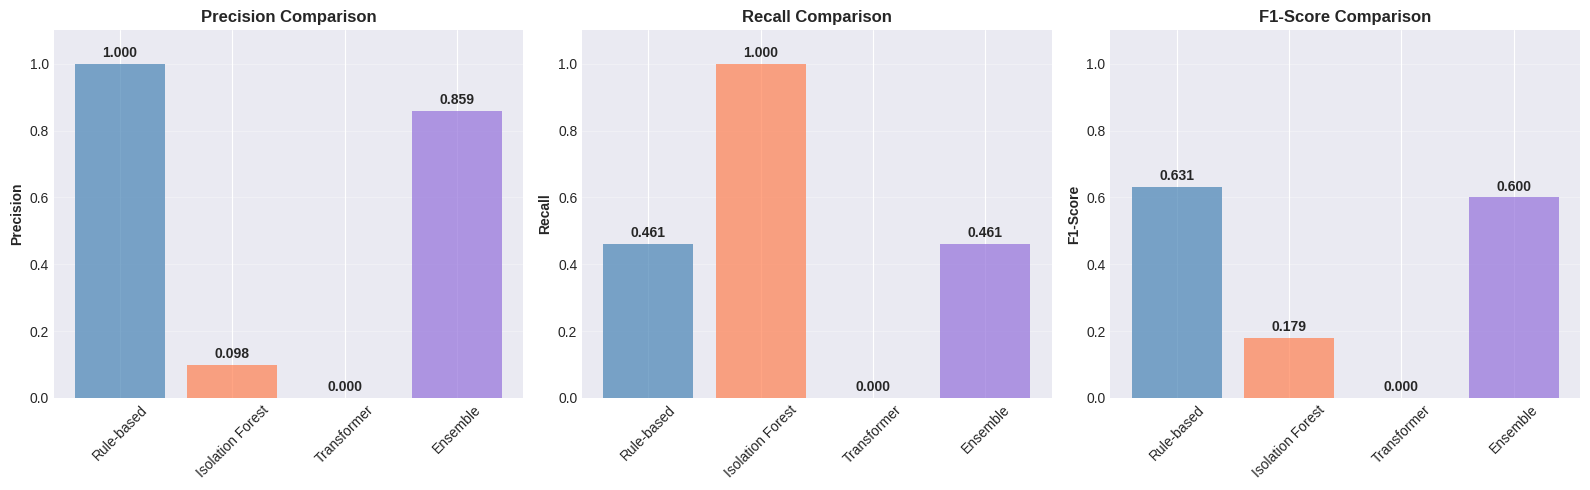

In [52]:
# Performance comparison bar chart
if 'true_label' in test_df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    metrics = ['Precision', 'Recall', 'F1-Score']
    colors = ['steelblue', 'coral', 'mediumseagreen', 'mediumpurple']
    
    for i, metric in enumerate(metrics):
        axes[i].bar(results_df['Method'], results_df[metric], color=colors, alpha=0.7)
        axes[i].set_ylabel(metric, fontweight='bold')
        axes[i].set_title(f'{metric} Comparison', fontweight='bold')
        axes[i].set_ylim([0, 1.1])
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for j, v in enumerate(results_df[metric]):
            axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/ensemble_inference_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

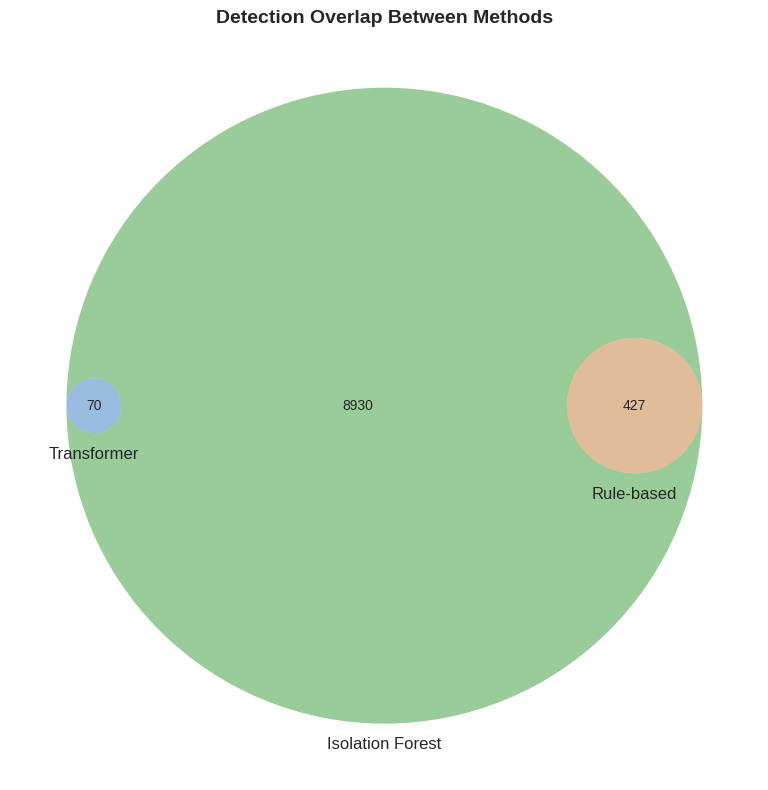

In [53]:
# Detection overlap Venn diagram (requires matplotlib_venn)
try:
    from matplotlib_venn import venn3
    
    rule_set = set(test_df[test_df['rule_is_attack']].index)
    iso_set = set(test_df[test_df['iso_is_anomaly'] == 1].index)
    transformer_set = set(test_df[test_df['transformer_is_anomaly'] == 1].index)
    
    plt.figure(figsize=(10, 8))
    venn3([rule_set, iso_set, transformer_set], 
          set_labels=('Rule-based', 'Isolation Forest', 'Transformer'))
    plt.title('Detection Overlap Between Methods', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/ensemble_inference_venn.png', dpi=300, bbox_inches='tight')
    plt.show()
except ImportError:
    print("⚠️  matplotlib_venn not installed, skipping Venn diagram")

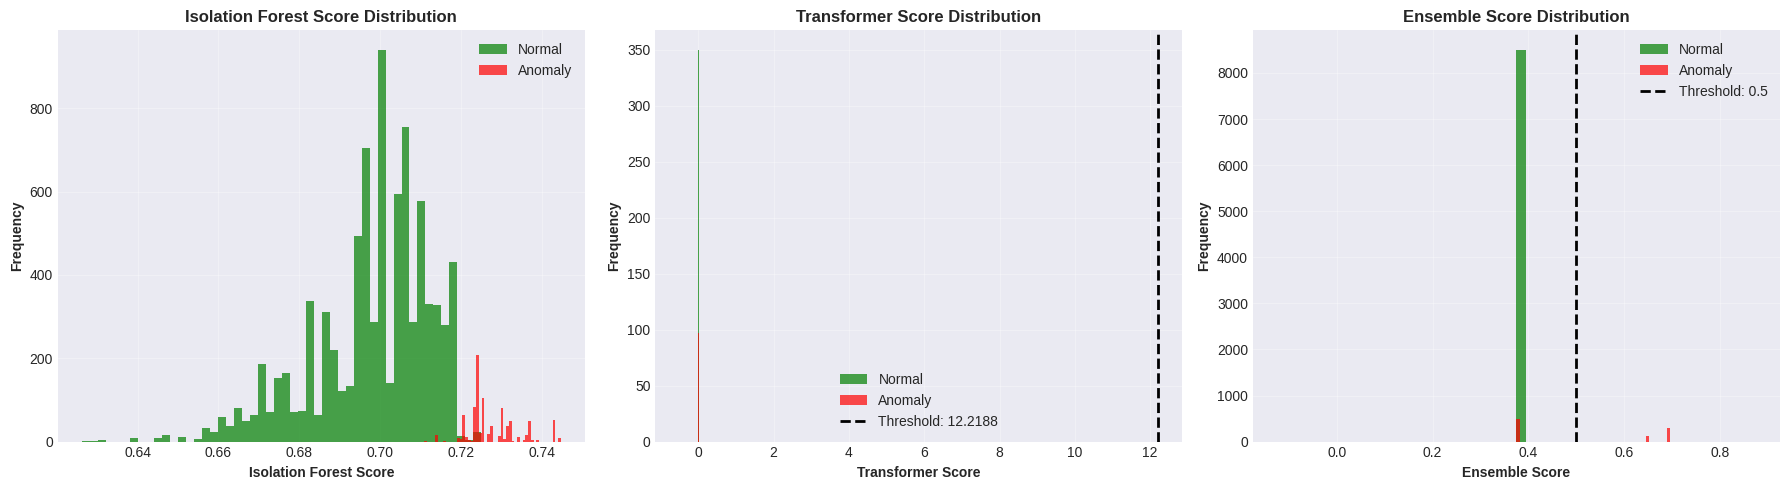

In [28]:
# Score distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Isolation Forest scores
axes[0].hist(test_df[test_df['true_label'] == 0]['iso_score'], bins=50, alpha=0.7, label='Normal', color='green')
axes[0].hist(test_df[test_df['true_label'] == 1]['iso_score'], bins=50, alpha=0.7, label='Anomaly', color='red')
axes[0].set_xlabel('Isolation Forest Score', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Isolation Forest Score Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transformer scores
axes[1].hist(test_df[test_df['true_label'] == 0]['transformer_score'], bins=50, alpha=0.7, label='Normal', color='green')
axes[1].hist(test_df[test_df['true_label'] == 1]['transformer_score'], bins=50, alpha=0.7, label='Anomaly', color='red')
axes[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {optimal_threshold:.4f}')
axes[1].set_xlabel('Transformer Score', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Transformer Score Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Ensemble scores
axes[2].hist(test_df[test_df['true_label'] == 0]['ensemble_score'], bins=50, alpha=0.7, label='Normal', color='green')
axes[2].hist(test_df[test_df['true_label'] == 1]['ensemble_score'], bins=50, alpha=0.7, label='Anomaly', color='red')
axes[2].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold: 0.5')
axes[2].set_xlabel('Ensemble Score', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].set_title('Ensemble Score Distribution', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/ensemble_inference_scores.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Sample Detections

Show examples of detected anomalies.

In [29]:
# Sample true positives (correctly detected attacks)
if 'true_label' in test_df.columns:
    true_positives = test_df[(test_df['true_label'] == 1) & (test_df['ensemble_is_anomaly'] == 1)]
    
    print(f"\n{'='*70}")
    print(f"SAMPLE TRUE POSITIVES (Correctly Detected Attacks)")
    print(f"{'='*70}")
    
    for i, row in true_positives.head(10).iterrows():
        print(f"\n[{i+1}] Attack Type: {row['attack_type']}")
        print(f"    Path: {row['path'][:80]}")
        print(f"    Detections:")
        print(f"      Rule-based: {'✓' if row['rule_is_attack'] else '✗'} (types: {row['rule_attack_types']})")
        print(f"      Isolation Forest: {'✓' if row['iso_is_anomaly'] else '✗'} (score: {row['iso_score']:.4f})")
        print(f"      Transformer: {'✓' if row['transformer_is_anomaly'] else '✗'} (score: {row['transformer_score']:.4f})")
        print(f"      Ensemble: ✓ (score: {row['ensemble_score']:.4f})")


SAMPLE TRUE POSITIVES (Correctly Detected Attacks)

[8501] Attack Type: sql_injection
    Path: /api/login?username=admin'--&password=x
    Detections:
      Rule-based: ✓ (types: ['command_injection'])
      Isolation Forest: ✓ (score: 0.7138)
      Transformer: ✗ (score: nan)
      Ensemble: ✓ (score: 0.6500)

[8502] Attack Type: sql_injection
    Path: /api/login?username=admin'--&password=x
    Detections:
      Rule-based: ✓ (types: ['command_injection', 'error_with_attack_pattern'])
      Isolation Forest: ✓ (score: 0.7303)
      Transformer: ✗ (score: nan)
      Ensemble: ✓ (score: 0.6957)

[8503] Attack Type: sql_injection
    Path: /api/login?username=admin'--&password=x
    Detections:
      Rule-based: ✓ (types: ['command_injection'])
      Isolation Forest: ✓ (score: 0.7138)
      Transformer: ✗ (score: nan)
      Ensemble: ✓ (score: 0.6500)

[8504] Attack Type: sql_injection
    Path: /api/login?username=admin'--&password=x
    Detections:
      Rule-based: ✓ (types: ['co

In [30]:
# Sample false negatives (missed attacks)
if 'true_label' in test_df.columns:
    false_negatives = test_df[(test_df['true_label'] == 1) & (test_df['ensemble_is_anomaly'] == 0)]
    
    print(f"\n{'='*70}")
    print(f"SAMPLE FALSE NEGATIVES (Missed Attacks)")
    print(f"{'='*70}")
    print(f"Total missed: {len(false_negatives):,}")
    
    if len(false_negatives) > 0:
        for i, row in false_negatives.head(5).iterrows():
            print(f"\n[{i+1}] Attack Type: {row['attack_type']}")
            print(f"    Path: {row['path'][:80]}")
            print(f"    Detections:")
            print(f"      Rule-based: {'✓' if row['rule_is_attack'] else '✗'}")
            print(f"      Isolation Forest: {'✓' if row['iso_is_anomaly'] else '✗'} (score: {row['iso_score']:.4f})")
            print(f"      Transformer: {'✓' if row['transformer_is_anomaly'] else '✗'} (score: {row['transformer_score']:.4f})")
            print(f"      Ensemble: ✗ (score: {row['ensemble_score']:.4f})")
    else:
        print("\n🎉 No false negatives! All attacks detected!")


SAMPLE FALSE NEGATIVES (Missed Attacks)
Total missed: 500

[8928] Attack Type: scanning
    Path: /admin
    Detections:
      Rule-based: ✗
      Isolation Forest: ✓ (score: 0.7236)
      Transformer: ✗ (score: nan)
      Ensemble: ✗ (score: 0.3750)

[8929] Attack Type: scanning
    Path: /phpmyadmin
    Detections:
      Rule-based: ✗
      Isolation Forest: ✓ (score: 0.7241)
      Transformer: ✗ (score: nan)
      Ensemble: ✗ (score: 0.3750)

[8930] Attack Type: scanning
    Path: /backup.sql
    Detections:
      Rule-based: ✗
      Isolation Forest: ✓ (score: 0.7241)
      Transformer: ✗ (score: nan)
      Ensemble: ✗ (score: 0.3750)

[8931] Attack Type: scanning
    Path: /admin
    Detections:
      Rule-based: ✗
      Isolation Forest: ✓ (score: 0.7241)
      Transformer: ✗ (score: nan)
      Ensemble: ✗ (score: 0.3750)

[8932] Attack Type: scanning
    Path: /.aws/credentials
    Detections:
      Rule-based: ✗
      Isolation Forest: ✓ (score: 0.7256)
      Transformer: ✗ (s

In [31]:
# Sample false positives (false alarms)
if 'true_label' in test_df.columns:
    false_positives = test_df[(test_df['true_label'] == 0) & (test_df['ensemble_is_anomaly'] == 1)]
    
    print(f"\n{'='*70}")
    print(f"SAMPLE FALSE POSITIVES (False Alarms)")
    print(f"{'='*70}")
    print(f"Total false alarms: {len(false_positives):,}")
    
    if len(false_positives) > 0:
        for i, row in false_positives.head(5).iterrows():
            print(f"\n[{i+1}] Status: {row['status']}")
            print(f"    Path: {row['path'][:80]}")
            print(f"    Detections:")
            print(f"      Rule-based: {'✓' if row['rule_is_attack'] else '✗'}")
            print(f"      Isolation Forest: {'✓' if row['iso_is_anomaly'] else '✗'} (score: {row['iso_score']:.4f})")
            print(f"      Transformer: {'✓' if row['transformer_is_anomaly'] else '✗'} (score: {row['transformer_score']:.4f})")
            print(f"      Ensemble: ✓ (score: {row['ensemble_score']:.4f})")
    else:
        print("\n🎉 No false positives! Perfect precision!")


SAMPLE FALSE POSITIVES (False Alarms)
Total false alarms: 0

🎉 No false positives! Perfect precision!


## 11. Summary Report

In [45]:
# Generate summary report
print(f"\n{'='*70}")
print(f"ENSEMBLE MODEL INFERENCE SUMMARY")
print(f"{'='*70}")
print(f"\nTest Dataset:")
print(f"  File: {log_file.name}")
print(f"  Total logs: {len(test_df):,}")
if 'true_label' in test_df.columns:
    print(f"  Normal: {(~test_df['true_label']).sum():,}")
    print(f"  Anomalous: {test_df['true_label'].sum():,}")

print(f"\nModel Configuration:")
print(f"  Transformer vocabulary: {vocab_size:,} templates")
print(f"  Vocabulary coverage: {coverage:.1f}%")
print(f"  Optimal threshold: {optimal_threshold:.4f}")
print(f"  Isolation Forest estimators: {iso_forest.n_estimators}")

print(f"\nDetection Results:")
print(f"  Rule-based: {test_df['rule_is_attack'].sum():,}")
print(f"  Isolation Forest: {test_df['iso_is_anomaly'].sum():,}")
print(f"  Transformer: {test_df['transformer_is_anomaly'].sum():,}")
print(f"  Ensemble: {test_df['ensemble_is_anomaly'].sum():,}")

if 'true_label' in test_df.columns:
    print(f"\nPerformance (Ensemble):")
    ensemble_metrics = results_df[results_df['Method'] == 'Ensemble'].iloc[0]
    print(f"  Accuracy:  {ensemble_metrics['Accuracy']:.4f}")
    print(f"  Precision: {ensemble_metrics['Precision']:.4f}")
    print(f"  Recall:    {ensemble_metrics['Recall']:.4f}")
    print(f"  F1-Score:  {ensemble_metrics['F1-Score']:.4f}")
    
    print(f"\nError Analysis:")
    print(f"  True Positives:  {cm[1,1]:,}")
    print(f"  True Negatives:  {cm[0,0]:,}")
    print(f"  False Positives: {cm[0,1]:,}")
    print(f"  False Negatives: {cm[1,0]:,}")

print(f"\n{'='*70}")
print(f"✓ Inference complete!")
print(f"{'='*70}")


ENSEMBLE MODEL INFERENCE SUMMARY

Test Dataset:
  File: synthetic_nodejs_apache_10k.log
  Total logs: 9,427
  Normal: 8,500
  Anomalous: 927

Model Configuration:
  Transformer vocabulary: 23,705 templates
  Vocabulary coverage: 11.0%
  Optimal threshold: 6.5602
  Isolation Forest estimators: 100

Detection Results:
  Rule-based: 427
  Isolation Forest: 9,427
  Transformer: 70
  Ensemble: 497

Performance (Ensemble):
  Accuracy:  0.9395
  Precision: 0.8592
  Recall:    0.4606
  F1-Score:  0.5997

Error Analysis:
  True Positives:  427
  True Negatives:  8,500
  False Positives: 0
  False Negatives: 500

✓ Inference complete!


## Next Steps

### If performance is good (F1 > 0.7):
- ✅ Model is ready for production deployment
- Consider testing on more diverse datasets
- Deploy as REST API or streaming service

### If performance needs improvement:
- 🔧 Analyze false negatives and false positives
- Consider retraining with combined datasets
- Adjust ensemble weights based on attack type
- Add more rule patterns for specific attacks

### For new synthetic logs:
- Generate more synthetic logs using `scripts/generate_synthetic_apache_logs.py`
- Vary attack types and intensity
- Test edge cases and evasion techniques